# Create Project

In [6]:
#import basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the Data

In [3]:
#create pandas dataframe
filename='Data/sales_predictions - sales_predictions (1).csv'
df = pd.read_csv(filename)


## Initial Data Inspection

In [4]:
#look at column ypes and datagrame head
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


- The data has loaded properly.

In [8]:
# check for rows and columns
df.shape


(8523, 12)

- There are 12 columns and 8,523 rows
- There is missing data in Item Weight and Outlet Size. 

# Initial Data Preparation and Cleaning

## Duplicated Values

In [11]:
# check for duplicates
df.duplicated().sum()

0

- There are no duplicated values. 

## Missing Values

In [13]:
#identify missing data
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [14]:
# there is missing data in "Item_weight" and "Outlet Size
# for exploratory visualization drop all missing values
df.dropna(inplace = True)


In [15]:
#double check dropped rows
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Check All Columns

- This are  many data issues with object columns.
 - Item Identifier, Item Visibility  and Item Weight have no obvious issues

In [19]:
#check the syntax and spelling errors
df['Item_Fat_Content'].value_counts()

Low Fat    2774
Regular    1575
LF          177
reg          71
low fat      53
Name: Item_Fat_Content, dtype: int64

- Spelling inconsistencies need to be addressed. 

In [21]:
# fix the inconsistencies
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
#check the column
df['Item_Fat_Content'].value_counts()

Low Fat    3004
Regular    1646
Name: Item_Fat_Content, dtype: int64

In [24]:
# check Item type
df['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Household', 'Baking Goods',
       'Snack Foods', 'Fruits and Vegetables', 'Breakfast',
       'Health and Hygiene', 'Frozen Foods', 'Hard Drinks', 'Canned',
       'Starchy Foods', 'Breads', 'Others', 'Seafood'], dtype=object)

In [25]:
# check outlet type
df['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2'], dtype=object)

In [27]:
# check outlet type
df['Outlet_Location_Type'].unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [28]:
#check the syntax and spelling errors
df['Outlet_Size'].value_counts()

Small     1860
Medium    1858
High       932
Name: Outlet_Size, dtype: int64

- All inconsistencies are addressed in object columns. 

# Preliminary Visuals

##  Functions for visuals

In [146]:
#function for categorical values
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
 
  # Make a copy of the dataframe and fillna 
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing 
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot 
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')
  
  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()
      
  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

In [29]:
# function for numeric values
def plot_numeric(df,col):
  ## make the figure and axes sharing the same x-axis
  fig, axes = plt.subplots(nrows=2, figsize=(10,5), sharex=True)

  ## Use seaborn plots with ax=axes[i]
  sns.histplot(data=df,x = col,ax = axes[0])
  mean_value = df[col].mean()
  axes[0].axvline(mean_value,color='red', ls='--', 
           label=f"Mean Value = ${mean_value:,.2f}",);

  med_value = df[col].median()
  axes[0].axvline(med_value,color='black', ls='--', 
           label=f"Median Value = ${med_value:,.2f}");


  sns.boxplot(data=df, x = col, ax = axes[1])

  ## Updating title of top graph 
  axes[0].set_title(f'EDA for {col}')

  ## Fixing any overlapping labels and showing
  plt.tight_layout()
  plt.show()

## Exploratory Visuals

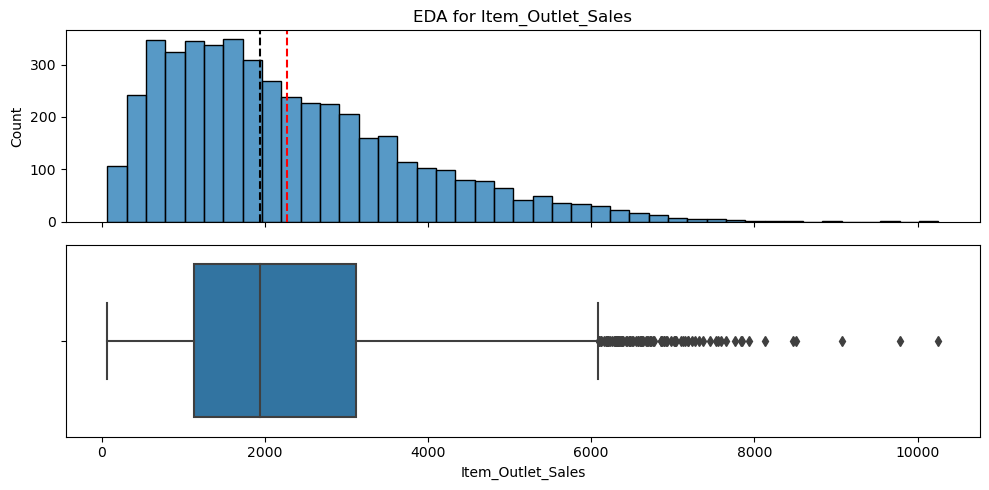

In [30]:
plot_numeric(df,'Item_Outlet_Sales')

- There are  outliers in the 8,000+ sales. 

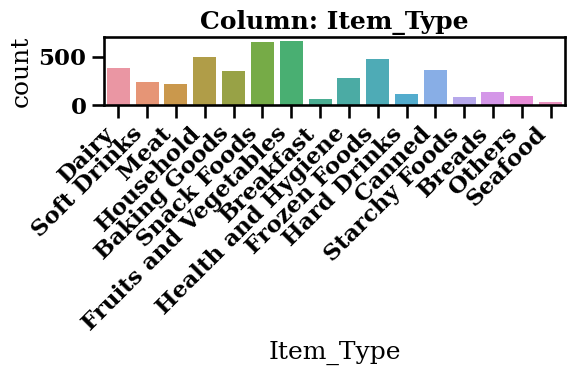

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 670 times (14.41%)
- Not constant or quasi-constant.


In [144]:
#explore categorical  values for item type
explore_categorical(df, 'Item_Type');


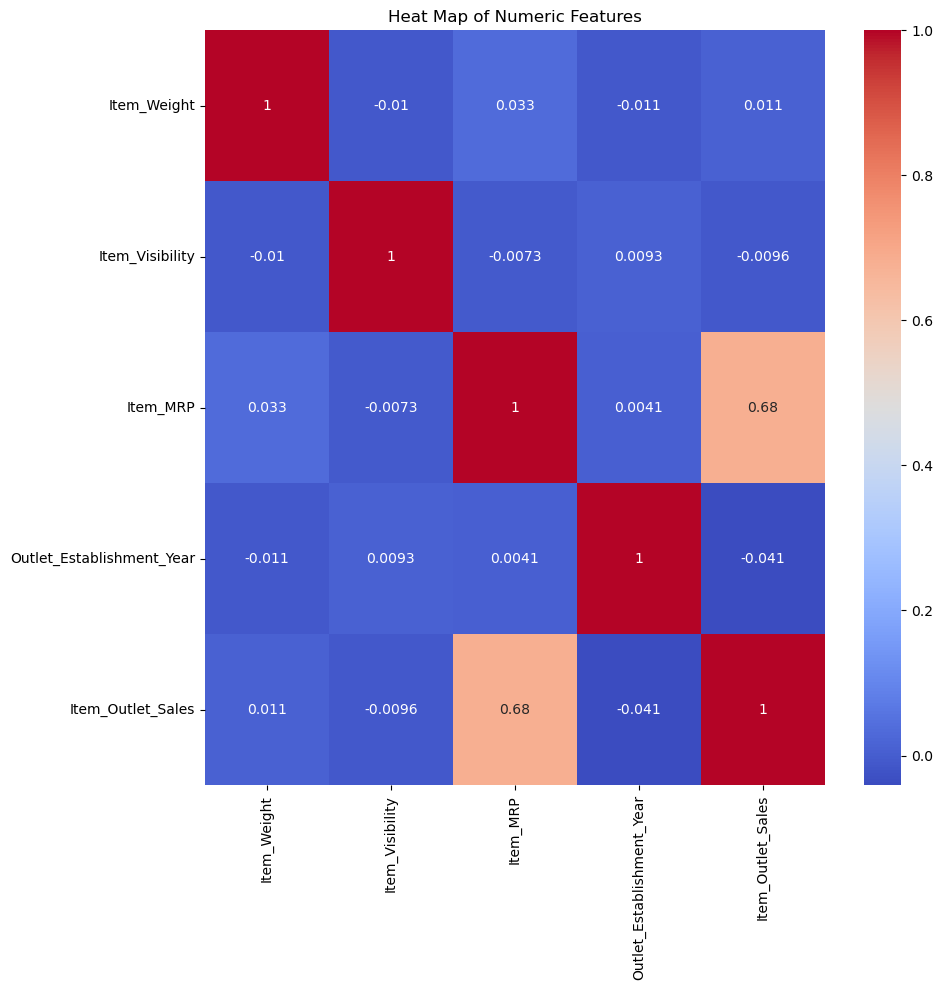

In [67]:
# look at heat map
fig, ax = plt.subplots(figsize=(10,10))
corr = df.corr(numeric_only = True)
sns.heatmap(corr,annot=True,cmap='coolwarm').set(title='Heat Map of Numeric Features');
plt.tight_layout()
plt.show()

- moderate correlation 
 - Item outlet sales and Item MRP. 
 - Outlet Establishment Year and Item MRP. 
- low negtive correlation 
 - Item Outlet Sales and Outet establishment year. 

In [145]:
def plot_categorical_vs_target(df, x, y='SalePrice',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna 
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x]) 
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  
    # Barplot 
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)
  
  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax, 
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  
  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax



## Visual for Correlated Features

### Item Outlet Sales and Item MRP

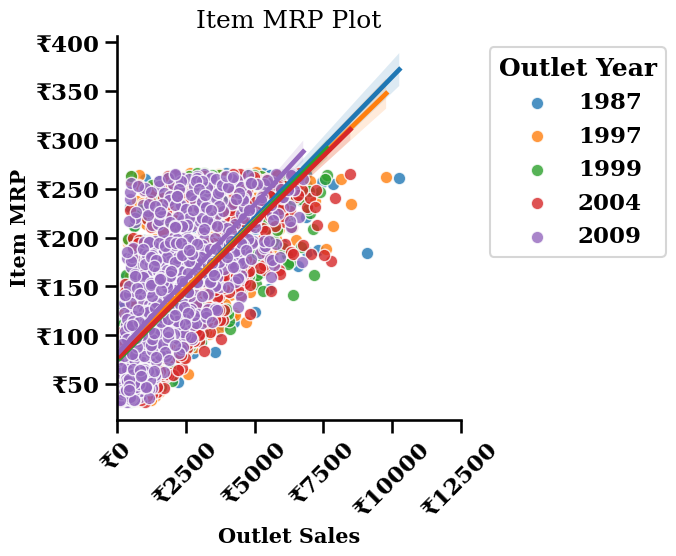

In [109]:
# create a regression plot 
scatter_kws = dict(edgecolor='white')
g = sns.lmplot(data=df, x="Item_Outlet_Sales", y="Item_MRP",
               scatter_kws=scatter_kws,
               hue="Outlet_Establishment_Year",
               legend=False);

g.ax.set_xlabel('Outlet Sales', fontfamily= 'serif', fontsize = 15, fontweight = 'bold')
g.ax.set_ylabel('Item MRP', fontfamily ='serif', fontsize = 15, fontweight = 'bold');
g.ax.spines['right'].set_visible(False)
g.ax.spines['top'].set_visible(False) 

# Relabel legend
g.ax.legend(title='Outlet Year', bbox_to_anchor=(1.05, 1))

#Format the sales in rupee and reset x and y axis
g.ax.yaxis.set_major_formatter('₹{x:1.0f}')
g.ax.xaxis.set_major_formatter('₹{x:1.0f}')
g.set_xticklabels(rotation=45)
g.set(xlim=(0, None))



g.ax.set_title("Item MRP Plot");
plt.savefig('Images/Scatter Plot  for Item MRP', bbox_inches='tight')


### Outlet Establishment Years and Item Outlet Sales

In [70]:
Year_Item_Sales = df.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].mean()
Year_Item_Sales

Outlet_Establishment_Year
1987    2298.995256
1997    2277.844267
1999    2348.354635
2004    2438.841866
2009    1995.498739
Name: Item_Outlet_Sales, dtype: float64

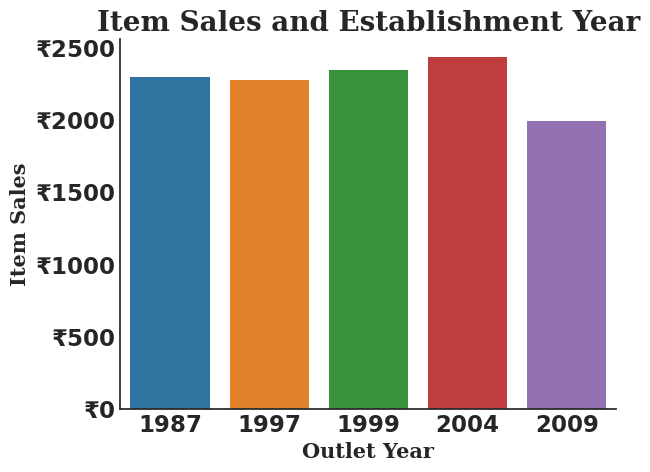

In [136]:
sns.set_context('talk')
with plt.style.context('seaborn-white'):
  fig, ax =plt.subplots()
plt.rcParams['font.family'] = 'serif'
ax = sns.barplot(data=df,x='Outlet_Establishment_Year', y = 'Item_Outlet_Sales', 
                 order = Year_Item_Sales.index, errorbar = None)
ax.set_title('Item Sales and Establishment Year', fontfamily='serif',
             fontsize = 20, fontweight = 'bold');
ax.set_xlabel('Outlet Year', fontfamily= 'serif', fontsize = 15, fontweight = 'bold')
ax.set_ylabel('Item Sales', fontfamily ='serif', fontsize = 15, fontweight = 'bold');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

scatter_kws = dict(edgecolor='white')
#Format the sales in rupee
ax.yaxis.set_major_formatter('₹{x:1.0f}')

#save current params
default_params = plt.rcParams.copy()

#update params
plt.rcParams.update ({'font.family': 'serif', 'font.size':'15', 'font.weight':'bold'})

plt.savefig('Images/Bar Plot for Sales and Year', bbox_inches='tight')


### Outlet Establishment Year and Item MRP.


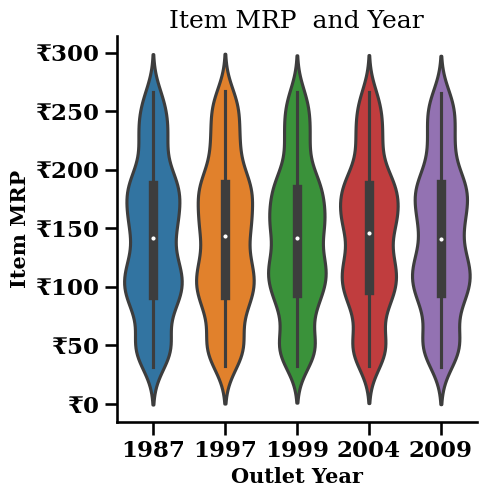

In [137]:
g=sns.catplot(data=df, x="Outlet_Establishment_Year", y="Item_MRP",
             hue="Outlet_Establishment_Year", kind='violin', dodge=False,
             title= "Item MRP and Outlet Year")

#set labels
g.ax.set_title("Item MRP  and Year");

g.ax.set_xlabel('Outlet Year', fontfamily= 'serif', fontsize = 15, fontweight = 'bold')
g.ax.set_ylabel('Item MRP', fontfamily ='serif', fontsize = 15, fontweight = 'bold');
g.ax.spines['right'].set_visible(False)
g.ax.spines['top'].set_visible(False) 

#Format the sales in rupee
g.ax.yaxis.set_major_formatter('₹{x:1.0f}')


plt.savefig('Images/Violin Plot for Item MRP and Year', bbox_inches='tight')

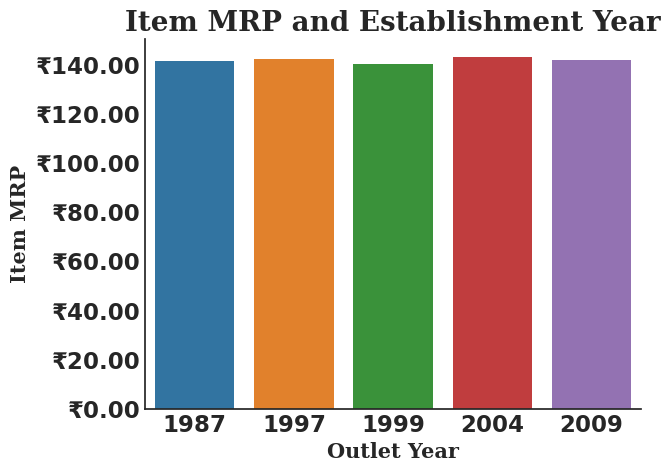

In [121]:
sns.set_context('talk')
with plt.style.context('seaborn-white'):
  fig, ax =plt.subplots()
plt.rcParams['font.family'] = 'serif'
ax = sns.barplot(data=df,x='Outlet_Establishment_Year', y = 'Item_MRP', 
                 order = Year_Item_Sales.index, errorbar = None)
ax.set_title('Item MRP and Establishment Year', fontfamily='serif',
             fontsize = 20, fontweight = 'bold');
ax.set_xlabel('Outlet Year', fontfamily= 'serif', fontsize = 15, fontweight = 'bold')
ax.set_ylabel('Item MRP', fontfamily ='serif', fontsize = 15, fontweight = 'bold');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

scatter_kws = dict(edgecolor='white')
#Format the sales in rupee
ax.yaxis.set_major_formatter('₹{x:1.2f}')

#save current params
default_params = plt.rcParams.copy()

#update params
plt.rcParams.update ({'font.family': 'serif', 'font.size':'15', 'font.weight':'bold'})

plt.savefig('Images/Bar Plot for Item MRP and Year', bbox_inches='tight')

## Big Picture EDA

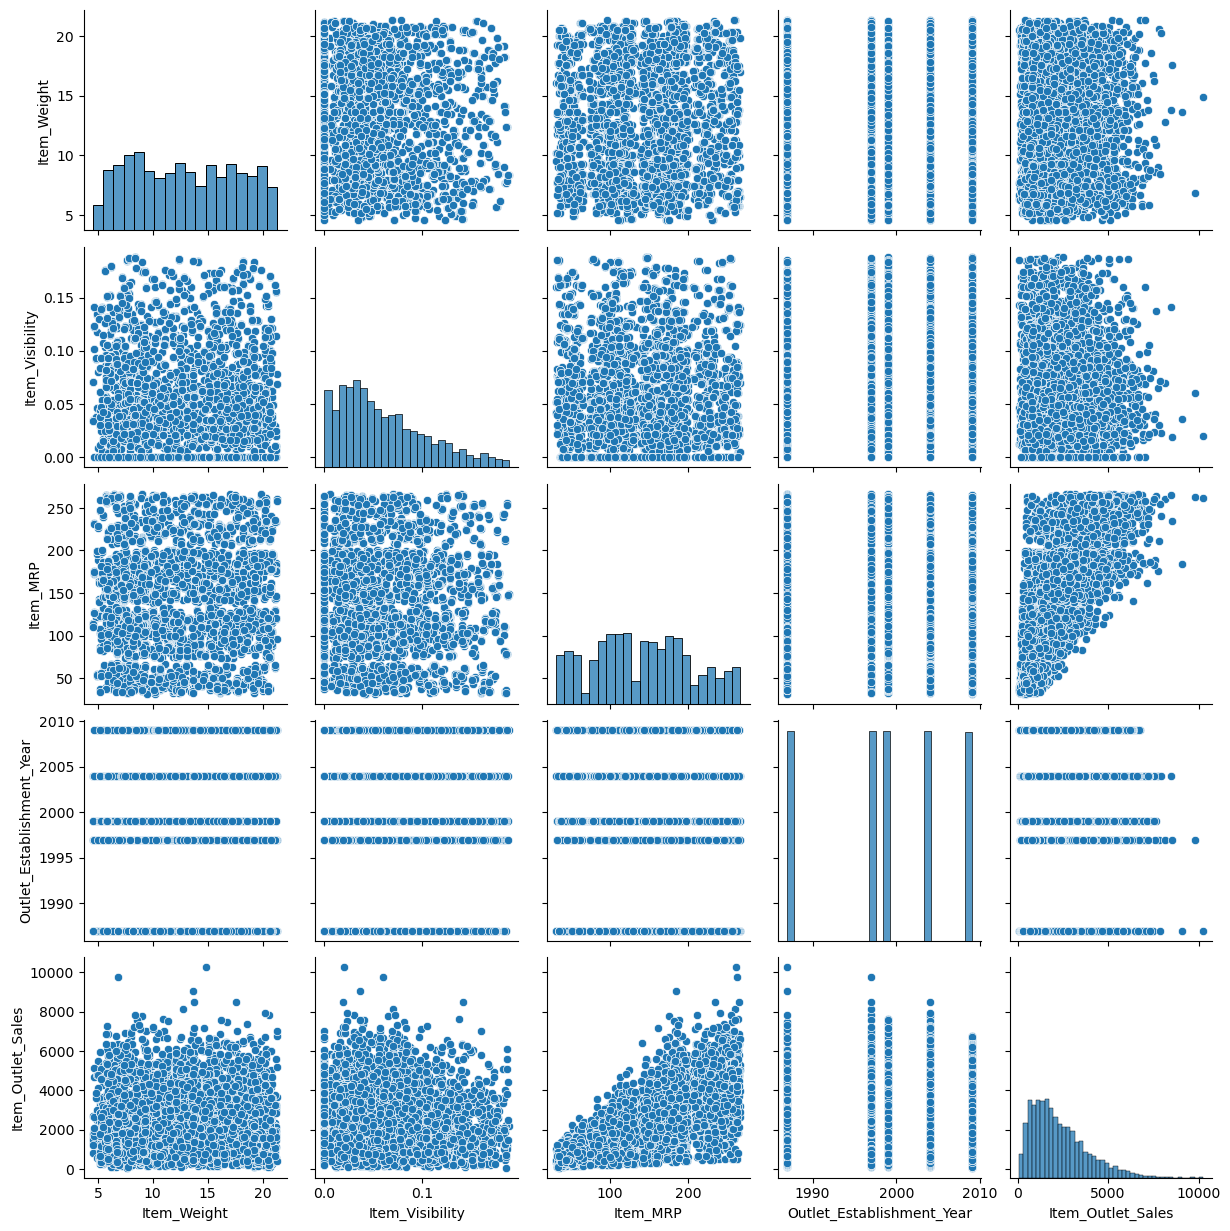

In [68]:
sns.pairplot(df);
